!*********************************************************************!

!

!   This program calculates the unpolarized absorption spectrum and 

!   band dispersion of a linear, 1D aggregate using the Frenkel/

!   charge-transfer Holstein model. See the README file for more 

!   information.

!                                                   Written By:

!                                                   Nicholas Hestand

!*********************************************************************!

In [1]:
import sys
import re
from os import path
import numpy as np
import scipy.linalg.lapack as lapack
import matplotlib.pyplot as plt
import seaborn as sns

# Common Variable

In [2]:
'''!*********************************************************************!
!      the kronecker delta function                                   !
!    kd( n, m ) = 1 if n = m, otherwise it is zero                    !
!*********************************************************************!'''
def kd(n,m):
    #integer, intent(in) :: n, m
    kd = 0
    if ( n == m ):
        kd = 1
    return kd

In [3]:
'''!*********************************************************************!
!    Module containing variables and parameters used in exciton1D     !
!    subroutines.
!*********************************************************************!'''
class load_commonvar():
    #module commonvar
    '''!=================================================================!
    !   Simulation parameters, all in units of hw                     !
    !=================================================================!'''
            #Simulation Title  
    task_title='task_title'

    nmol = int(1)

            #!Vibrational Parameters
    vibmax    = int(0)      #!Max vibrations in basis set
    hw        = 1400.0      #!vibration energy
    lambda_n  = 1.0         #!Neutral lambda (harmonic shift)
    lambda_c  = 0.0         #!Cation lambda (harmonic shift)
    lambda_a  = 0.0         #!Anion lambda (harmonic shift)

            #!Coupling and Energies
    JCoul     = 0.0        #!Nearest neighbor Coulomb coupling
    ES1       = 0.0        #!Monomer Transition Energy
    te        = 0.0        #!Nearest neighbor electron transfer integral
    th        = 0.0        #!Nearest neighbor hole transfer integral
    ECT       = 0.0        #!Charge Transfer Energy
    ECTInf    = 0.0        #!Charge Transfer Energy and Infinite Separation

            #!multiparticle basis states
    one_state    =True
    two_state    =False
    ct_state     =False

            #!absorption linewidth
    abs_lw   = 0.10

            #!franck condon tables
    fc_gf=np.empty([1,1])
    fc_gc=np.empty([1,1])
    fc_ga=np.empty([1,1])
    fc_af=np.empty([1,1])
    fc_cf=np.empty([1,1])

    fc_gf[:]=np.nan
    fc_gc[:]=np.nan
    fc_ga[:]=np.nan
    fc_af[:]=np.nan
    fc_cf[:]=np.nan

            #!constants
    pi = 4.0*np.arctan(1.0)
            #!cm-1 per electronvolt
    ev = 8065.0
            #!plancks constant times the speed of light in nm*hw 
    hc = 1.23984193e3 * ev 
            #!boltzman constant units of cm-1 k
    kbman = 0.6956925 
            #!reduced planks constant in wavenumber * s
    hbar = 6.58211951440e-16 * ev 

            #!basis set counter
    kount = int(0)

            #!basis set indexes
    nx_1p=np.empty([1])
    nx_1p[:]=np.nan
    nx_2p=np.empty([1,1,1])
    nx_2p[:]=np.nan
    nx_ct=np.empty([1,1,1])
    nx_ct[:]=np.nan

            #!the hamiltonian and eigenvalues
    h=np.empty([1,1],dtype='complex')
    eval=np.empty([1])
    h[:]=np.nan
    eval[:]=np.nan

            #!empty parameter
    empty = -1  
            #!parameters for complex numbers
    complex_zero = complex( 0.0, 0.0 )
    img = complex( 0.0, 1.0 )

            #!bounds integer 
    nlbnd=None
    nubnd=None

            #!number of eigenstates to find for each k
    esnum = 1    

# read in parameters


In [4]:
'''!*********************************************************************!
!   subroutine reads parameters from user input file 
!   most variables reside in the commonvar module and are used
!   throughout the program in various subroutines
!*********************************************************************!'''
def read_in_para(parameters):

    #logical         exists
    #character*100   buff, label, fname
    #integer         fno, ios, line, pos, errstat
    #parameter       (fno = 201)
    #get the input file name as the first argument from command line
        #fname=sys.argv[1]
    try:
        fname='/Users/livi/Git/exciton1d-1/PYexamplePLUS.inp'
    except:
    #if given otherwise use default parameters    
        print('No control file given. Using default parameters')
        parameters=c1010(parameters)
        return parameters
    #check that the given input file exists, abort if not
        if not path.exists(fname):
            print('Input file not found...aborting')
            return
    #open the user input file and read in the parameters
    with open(fname,'r',encoding='utf-8') as f:
        #ios = 0  #the in/out status
        #line = 0 #the current line number
        print('Reading the input file...'+'\n'+'**********************************'+'\n'+'**********************************')
        #parameters=['task_title','nmol','vibmax','hw','lambda_n','lambda_c','lambda_a','JCoul','ES1','te','th','ECT','ECTInf','one_state','two_state','ct_state','abs_lw','esnum']
        for buff in f.readlines():#!continue the loop until end of file,!read a line
            if buff.startswith('#'): #treat as a comment
                continue
            else:#find the label and assign the appropriate value to the variable
                label_buff=buff.split()
                if label_buff[1].isalnum():
                    if (not label_buff[1].isnumeric()) and (label_buff[1] not in ['True', 'False']):
                        label_buff[1]=chr(39)+label_buff[1]+chr(39)
                label,buff= label_buff[0],label_buff[1]#parse the line into a label and parameter
                try:
                    exec('parameters.'+label+'='+buff)#eval would not work
                except:
                    input('invalid label at line','\n',label,'\n','press enter to continue or ctrl+c to abort')
    parameters=c1010(parameters)
    #print(vars(parameters))
    print('**********************************'+'\n'+'**********************************')
    return parameters
    
def c1010(parameters):#not very sure about the function here
    print('Calculating derived parameters in units of hw.')

    #normalize parameters to units of hw    
    parameters.JCoul  = parameters.JCoul /  parameters.hw
    parameters.ES1    = parameters.ES1   /  parameters.hw
    parameters.te     = parameters.te    /  parameters.hw
    parameters.th     = parameters.th    /  parameters.hw
    parameters.ECT    = parameters.ECT   /  parameters.hw
    parameters.ECTInf = parameters.ECTInf/  parameters.hw
    parameters.abs_lw = parameters.abs_lw/  parameters.hw
    
    #Set all Huang-Rhys factors to zero if vibmax is zero
    #This assumes that the user just wants to calculate the
    #free exciton properties
    if (parameters.vibmax  == 0 ):
        parameters.lambda_n = 0
        parameters.lambda_c = 0
        parameters.lambda_a = 0
        print('(a)', '>> vibmax is zero. Setting all lambda to zero')

    #set the maximum left and right displacement from a given molecule given periodic boundary conditions
    parameters.nlbnd =  int(-parameters.nmol/2+(1-1*np.mod(parameters.nmol,2)))
    parameters.nubnd =   int(parameters.nmol/2)
    return parameters

# number of particles


In [5]:
'''!*********************************************************************!
!                    index the 1 p k states                           !
!A 1-particle k-state is defined in terms of 1-particle local states  !
!as:                                                                  !
!                                                                     !
!   |k,v> = SUM_n exp(i*2*pi*k*n/N)|n,v> / sqrt(N)                    !
!                                                                     !
!   where the vibrations v are in the shifted potential well,         !  
!   molecule n is excited and all other molecules are in their        !
!   ground electronic and vibrational state                           !
!   In this program, we only work with one k-submatrix at a time      !
!   so only the number of vibratons needs to be indexed               !
!*********************************************************************!'''
def index_1p(p):
    #integer vib
    #allocate the indexing array and initialize as empty
    #index the 1-particle basis states
    #|k,vib> -> nx_1p( vib )
    
    p.nx_1p=np.empty([p.vibmax])
    p.nx_1p[:]=np.nan
    for vib in range( 0, p.vibmax):
        p.kount = p.kount + 1
        p.nx_1p[vib] = p.kount
    return p
    
'''!*********************************************************************!
!                  index the 2-particke k states                      !
!A 2-particke k-state is defined in terms of the local states as      !
!                                                                     !
!    |k,v;s,v'> = SUM_n exp(i*2*pi*k*n/N)|n,v;n+s,v'>                 !
!                                                                     !
!where v is the number of vibrations in the shifted potential well    !
!of excited molecule n, and v' is the number of vibrations in the     !
!unshifted well of molecule n+s. All other molecules are in their     !
!ground electronic and vibrational states.                            !
!*********************************************************************!'''
def index_2p(p):
    #integer vib, s, svib
    #allocate the indexing array and set as empty
    #print([p.vibmax,p.nubnd-p.nlbnd,p.vibmax-1])
    p.nx_2p=np.empty([p.vibmax,p.nubnd-p.nlbnd,p.vibmax-1])    
    p.nx_2p[:]=np.nan
    #index the two-particle basis states
    #|k,vib;s,svib> -> nx_2p( vib, s, svib )
    for vib in range(0,p.vibmax):#vibration on electronexcited molecule
        for s in range(p.nlbnd,p.nubnd):#displacement from electronic excited
            if s==0:#displacement cannot be zero
                break
            for svib in range(1, p.vibmax):#vibration on ground state molecule
                if ( vib + svib > p.vibmax ):#truncate at vibmax
                    break  #truncate at vibmax
                p.kount = p.kount + 1
                p.nx_2p[vib, s-p.nlbnd, svib-1] = p.kount#fortran start 1, python 0.
    return p

'''!*********************************************************************!
!          index the 2-particle charge-transfer  k states             !
!A charge-transfer 2-particle k-state is defined in terms of local    !
!charge transfer states as                                            !
!                                                                     !
!    |k,v;s,v'> = SUM_n exp(i*2*pi*k*n/N)|n,v;n+s,v'> / sqrt(N)       !
!    where n is the cationic molecule with v vibrational quanta       !
!    in the shifted potential well and n+s is the anionic molecule    !
!    with v' vibrational quanta in its shifted well. All other        !
!    molecules are assumed to be in their ground states               !
!*********************************************************************!'''
def index_ct(p):
    #integer cvib, s, avib
    #allocate the 2-particle charge-transfer index and 
    #initialize as empty
    p.nx_ct=np.empty([p.vibmax,p.nubnd-p.nlbnd,p.vibmax])
    p.nx_ct[:]=np.nan
    #index the 2-particle charge-transfer states
    #|k,cvib;s,avib> -> nx_ct( cvib, s, avib )
    for cvib in range(0,p.vibmax):#vibration on cation molecule
        for s in range(p.nlbnd,p.nubnd):#!anion displacement from cation
            if s==0:#!displacement cant be zero
                break
            for avib in range(0,p.vibmax):#vibration on anion molecule
                if (cvib+avib>p.vibmax):#truncate at vibmax
                    break
                p.kount+=1
                p.nx_ct[cvib,s-p.nlbnd,avib]=p.kount
    return p

# Frank Condon Table

In [6]:
'''!********************************************************************!
!    Return the vibrational overlap for displaced harmonic           !
!    oscillators. The lambda are proportional to the well minimum    !
!    and when squared are equivalent to the Huang-Rhys parameter.    !
!    The vibrational overlap factors are given by the formula        !
!                                                                    !
!    <m|n>=sqrt(m!n!)exp(-lambda^2/2) *                              !
!          SUM_l^(min(m,n))                                          !
!                (-1)^(m-l)/[(m-l)!l!(n-l)!] *                       !
!                lambda^(m+n-2l)                                     !
!                                                                    !
!    which can be derived from the recursion relations found         !
!    on page 167 of MODERN OPTICAL SPECTROSCOPY                      !
!    here lambda is proportional to the equilibrium displacement     !
!******************x**************************************************!'''
def volap( lambda1, vib1, lambda2, vib2 ):
    #integer, intent (in) :: vib1, vib2
    #real*8, intent(in) :: lambda1, lambda2
    #integer k
    #integer, external :: factorial
    #real*8 lambda
    
    #!calculate the displacement between the two potential wells
    lamb = lambda2 - lambda1

    volap = 0
    #calculate the vibrational overlap
    #first calculate the summation
    for k  in range(0, min( vib1, vib2 )):
        volap = volap+(-1.0)**(vib2-k)/                         \
            (np.math.factorial(vib1-k)*np.math.factorial(k)*    \
                 np.math.factorial(vib2-k))*                    \
                 lamb**(vib1+vib2-2*k)
    if (not vib2<0) and (not vib1<0):
        volap = volap*np.sqrt(1.0*np.math.factorial(vib1)*  \
                                np.math.factorial(vib2))*   \
                                np.exp (-1.0*          \
                                lamb**2/2.0)
    return volap

'''!********************************************************************!
!     initialize the vibrational overlap tables                      !
!********************************************************************!'''
def set_fctable(p):
    #integer vibg, vibn, vibc, viba
    #real*8, external :: volap

    #allocate space for the vibrational overlap tables
    p.fc_gf=np.empty([p.vibmax,p.vibmax])
    p.fc_gc=np.empty([p.vibmax,p.vibmax])
    p.fc_ga=np.empty([p.vibmax,p.vibmax])
    p.fc_cf=np.empty([p.vibmax,p.vibmax])
    p.fc_af=np.empty([p.vibmax,p.vibmax])

    p.fc_gf[:]=np.nan
    p.fc_gc[:]=np.nan
    p.fc_ga[:]=np.nan
    p.fc_cf[:]=np.nan
    p.fc_af[:]=np.nan

    #!Generate the vibrational overlap tables. Ground state potential
    #!well minimum is the reference, all others are shifted by !lambda

    # ground to frenkel
    for vibg in range(0,p.vibmax):
        for vibn in range(0,p.vibmax):
            p.fc_gf[vibg, vibn] = volap( 0.0, vibg, p.lambda_n, vibn )

    #!ground to cation
    for vibg in range(0,p.vibmax):
        for vibc in range(0,p.vibmax):
            p.fc_gc[vibg, vibc] = volap( 0.0, vibg, p.lambda_c, vibc )
        
    #ground to anion
    for vibg in range(0,p.vibmax):
        for viba in range(0,p.vibmax):
            p.fc_ga[vibg, viba] = volap( 0.0, vibg, p.lambda_a, viba )

    #cation to frenkel
    for vibn in range(0,p.vibmax):
        for vibc in range(0,p.vibmax):
            p.fc_cf[vibc, vibn] = volap( p.lambda_c, vibc, p.lambda_n, vibn )
    
    #anion to frenkel
    for vibn in range(0,p.vibmax):
        for viba in range(0,p.vibmax):
            p.fc_af[viba, vibn] = volap( p.lambda_a, viba, p.lambda_n, vibn )
    return p

# Build Hamiltonian

In [7]:
'''!*********************************************************************!
!   Helper function to keep indices inside the range [nlbnd, nubnd]   !
!*********************************************************************!'''
def bring_inside_nxrange(s,p):
    #integer, intent(in) :: s
    bring_inside_nxrange = s
    if ( s > p.nubnd ):
        bring_inside_nxrange = s - p.nmol
    if ( s < p.nlbnd  ):
        bring_inside_nxrange = s + p.nmol
    return bring_inside_nxrange

'''!*********************************************************************!
!             build the 1-particle hamiltonian                        !
!   The diagonal energies are given by                                ! 
!   <k,v|H|k,v> = ES1 + v*hw + J(k)*FC(0,v)*FC(0,v)                   !
!   Where J(k) arises from the Coulomb coupling and depends on the    !
!   number of nearest neighbors:                                      !
!   For zero neighbors (i.e. a monomer) J(k) = 0                      !
!   For one neighbor (i.e. a dimer ) J(k) = JCoul*cos(k)              !
!   For two neighbors (nmol >2) J(k) = 2 JCoul*cos(k)                 !
!   and FC(0,v) is the vibrational overlap factor                     !
!   Below J(k) is calculated as                                       !
!                                                                     !
!   Off diagonal entries are given by                                 !
!   <k,v|H|k,v'> = J(k)*FC(0|v)*FC(0|v')                              !
!*********************************************************************!'''
def build_h1p(k,p):
    #integer, intent(in) :: k
    #integer vib1, vib2, h1, h2
    #real*8 Jk 

    #choose the first basis element |k,vib1>
    for vib1 in range(0, p.vibmax):
        h1 = int(p.nx_1p[vib1]) #get the basis index

        #Add the vibrational and monomer energy to the diagonal
        p.h[ h1, h1 ] = vib1*1.0 + p.ES1

        #choose the second basis element |k,vib2> 
        # and calculate J(k)*FC(0,vib1)*FC(0,vib2)
        for vib2 in range(0, p.vibmax):
            h2 = int(p.nx_1p[vib2]) #get the basis index
            
            #calculate Jk
            if ( p.nmol == 1 ):
                Jk = 0.0
            elif ( p.nmol == 2 ):
                Jk = p.JCoul * np.cos( 2*np.pi*k/p.nmol )
            else:
                Jk = 2.0 * p.JCoul * np.cos( 2*np.pi*k/p.nmol )

            #multiply by the volap factors and assign
            p.h[h1, h2] = p.h[h1,h2] + Jk * p.fc_gf[0,vib1] * p.fc_gf[0,vib2]
    return p

'''!*********************************************************************!
!             build the 2-particle hamiltonian                        !
!There are two types of coupling possible:                            !
!                                                                     !
!   Linker Coupling:                                                  !
!   Here the ground state vibrations must be the same and the exciton !
!   moves s-s' molecules. This is just like coupling 1P 1P states     !
!   except there is now a vibrational excitation as well              !
!   <k,v,s,v'|H|k,v'',s',v'> =                                        !
!               exp(-i*2*pi*k*(s'-s)/N)*JCoul*FC(0|v)*FC(0|v'')       !
!   where it must be the case that abs(s'-s) = 1 (the exciton moves   !
!   one unit)                                                         !
!                                                                     !
!   Exchange Coupling:                                                !
!   Here, the exciton moves to the vibrationally excited molecule     !
!   This is different than the 1-particle, 1-particle coupling        !
!   <k,v,s,v'|H|k,v'',-s,v\'''> =                                      ! 
!               exp(-i*2*pi*k*s/N)*JCoul*FC(v\'''|v)FC(v'|v'')         !
!*********************************************************************!'''
def build_h2p(k,p):
    #integer, intent(in) :: k
    #integer vib1, s1, vibv1, vib2, s2, vibv2, h1, h2, ds
    #complex*16 cpl_sum, modulate
    
    #choose the first basis element |k,vib1,s1,vibv1>
    for vib1 in range(0,p.vibmax):
        for s1 in range(p.nlbnd, p.nubnd):
            for vibv1 in range(1, p.vibmax):
                h1 = p.nx_2p[vib1, s1-p.nlbnd, vibv1-1]#get the basis index
                if (np.isnan(h1)):#if h1 is empty
                    break       #and check to make sure it is in the basis sets
                else:
                    h1=int(h1)

                #Add the vibrational and monomer energy to the diagonal
                p.h[h1,h1] = ( vib1 + vibv1 ) * 1.0 + p.ES1

                #choose the second basis element |k,vib2,s2,vibv2>
                for vib2 in range(0, p.vibmax):
                    for s2 in range(p.nlbnd, p.nubnd):
                        for vibv2 in range(1, p.vibmax):
                            h2 = p.nx_2p[vib2, s2-p.nlbnd, vibv2-1] #get the basis index
                            if (np.isnan(h2)):#if h2 is empty
                                break                     #and check to make sure
                            else:
                                h2=int(h2)                #it is in the basis set
                                                          
                            #calculate the coupling term
                            cpl_sum = p.complex_zero #initialize to zero

                            #LINKER TYPE COUPLING
                            if ( vibv1 == vibv2 ):
                                #!calculate the distance of exciton transfer
                                ds = s1 - s2

                                #!bring inside the aggregate range, if outside
                                if ( ds < p.nlbnd ):
                                    ds = ds + p.nmol
                                if ( ds > p.nubnd ):
                                    ds = ds - p.nmol

                                #!add the coupling to the coupling sum... There
                                #!is only nearest neighbor couping and the phase
                                #!depends on whether the exciton is going "left"
                                #!or "right"
                                if ( ds == 1) or (ds == -1 ):
                                    modulate = np.exp( -2.0*np.pi*p.img*k*ds/(1.0*p.nmol))
                                    cpl_sum = cpl_sum + modulate * p.JCoul *              \
                                                    p.fc_gf[0,vib1]*p.fc_gf[0,vib2]         \

                            #!EXCHANGE TYPE COUPLING
                            if ( s1 == -s2 ):
                                #!the distance of exciton transfer is s1
                                ds = s1
                                #!add the coupling to the coupling sum... There
                                #!is only nearest neighbor coupling and the phase
                                #!depends on whether the exciton is going "left" or !"right"
                                if ( s1 == -1) or (s1 == 1):
                                    modulate = np.exp( -2.0*np.pi*p.img*k*ds/(1.0*p.nmol))
                                    cpl_sum = cpl_sum + modulate * p.JCoul *               \
                                                p.fc_gf[vibv2-1,vib1]*p.fc_gf[vibv1-1,vib2]
                            
                            #!EXCHANGE TYPE II - SELF EXCHANGE FOR EVEN LATTICES
                            #!(this will really only affect the dimer case)
                            if ( s1 == s2 ):
                                #!the distance of exciton transfer is s1
                                ds = s1
                                #!This will only happen for even lattices when s1
                                #!is equal to nmol/2
                                if ( np.mod( p.nmol, 2 ) == 0) and (abs(s1) == p.nmol/2):
                                #!add the coupling to the coupling sum... There
                                #!is only nearest neighbor coupling and the phase
                                #!depends on whether the exciton is going "left" or "right"
                                    if ( s1 == -1) or (s1 == 1 ):
                                        modulate = np.exp( -2.0*np.pi*p.img*k*ds/(1.0*p.nmol))
                                        cpl_sum = cpl_sum + modulate * p.JCoul *              \
                                                        p.fc_gf[vibv2-1,vib1]*p.fc_gf[vibv1-1,vib2]
                            #!add the coupling to the Hamiltonian
                            p.h[h1, h2] = p.h[h1, h2] + cpl_sum
    return p
                
'''!*********************************************************************!
!             build the 1-particle 2-particle hamiltonian             !
!   The 1-particle 2-particle matrix elements are given by            !
!   <k,v|H|k,v',s,v''>=                                               !
!                   exp(i*2*pi*k*s/N)*JCoul*FC(v''|v)*FC(0|v')        !
!
!   These are like the exchange type couplings for the 2-particle     !
!   Hamiltonian.                                                      !
!*********************************************************************!'''
def build_h1p2p(k,p):
 
    #integer, intent(in) :: k
    #integer vib1, vib2, s2, vibv2, h1, h2, ds
    #complex*16 cpl_sum, modulate
    
    #!choose the 1-particle basis set |k,vib1>
    for vib1 in range(0, p.vibmax):
        h1 = p.nx_1p[vib1]   #! get the basis index and make sure it 
        if (np.isnan(h1)):#if h1 is empty
            break #!is in the basis set
        else:
            h1=int(h1)

        #!choose the 2-particle basis set |k,vib2;s2,vibv2>
        for vib2 in range(0, p.vibmax):
            for s2 in range(p.nlbnd, p.nubnd):
                for vibv2 in range(1, p.vibmax):
                    h2 = p.nx_2p[vib2,s2-p.nlbnd, vibv2-1] #get the basis index and make
                    if (np.isnan(h2)):
                        break                     #!sure it is in the basis set
                    else:
                        h2=int(h2)
                    
                    #!the exciton moves -s2
                    ds = -s2

                    #!EXCHANGE TYPE COUPLING
                    #!only include nearest neighbor coupling
                    if ( ds == -1) or (ds == 1 ):
                        modulate = np.exp( -2.0*np.pi*p.img*k*ds/(1.0*p.nmol))
                        p.h[h1, h2] = modulate * p.JCoul *                  \
                                    p.fc_gf[vibv2-1,vib1]*p.fc_gf[0,vib2]
                                
                    #Also set the Hermitian Conjugate here
                    p.h[h2, h1] = np.conjugate( p.h[h1, h2] )
    return p

'''!*********************************************************************!
!                      build the ct hamiltonian                       !
!    The diagonal energies are:                                       !
!    <k,v;s,v'|H|k,v;s,v'> = ECT(s) + (v+v')*hw                       !
!    where ECT(s) = [ECTInf*(s-1) - ECT]/s                            !
!    ECTInf is the energy of a CT state separated to infinity         !
!                                                                     !
!    The off diagonal matrix elements are:                            !
!    <k,v;s,v'|H|k,v'';s',v\'''> =                                     !
!           te*FC(0|v')*FC(0|v\''')*kd(v|v'') +                        !
!           th*exp(-i*2*pi*k*(s'-s))*FC(0|v)*FC(0|v'')*kd(v'|v\''')    !
!    for |s-s'|=1 and zero otherwise. Here kd is the kronecker delta  !
!*********************************************************************!'''
def build_hct(k,p):
    #integer, intent(in) :: k
    #integer vibc, sa, viba, h1, vibc2, sa2, viba2, h2, s, bring_inside_nxrange, kd

    #! get the diagonal energies
    #! choose the charge-transfer state |k,vibc,sa,viba>
    for vibc in range(0, p.vibmax):
        for sa in range(p.nlbnd, p.nubnd):
            for viba in range(0, p.vibmax):
                h1 = p.nx_ct[vibc, sa-p.nlbnd, viba] #!get the basis index and check
                if (np.isnan(h1)):
                    break     #!that it is not empty
                else:
                    h1=int(h1)

                #! assign the energy 
                s = abs(sa)
                p.h[h1, h1 ] = (p.ECTInf*(s-1) + p.ECT)/(s*1.0) + (vibc + viba)*1.0

                #! choose the second basis element k, vibc2, sa2, viba2
                for vibc2 in range(0, p.vibmax):
                    for sa2 in range(p.nlbnd, p.nubnd):
                        for viba2 in range(0, p.vibmax):
                            h2 = p.nx_ct[vibc2, sa2-p.nlbnd, viba2]  # get the basis index and
                            if (np.isnan(h2) ):
                                break       # check that not empty
                            else:
                                h2=int(h2)
                            #! calculate the electron/hole displacement
                            s = bring_inside_nxrange(sa2-sa,p)
                            if ( abs(s)!= 1):
                                break       #! only nearest neighbor
                                            #! charge transfer allowed
                            #! calculate the matrix element
                            p.h[h1, h2] = p.te * p.fc_ga[0,viba]*p.fc_ga[0,viba2]*kd(vibc, vibc2) + \
                                        p.th * p.fc_gc[0,vibc]*p.fc_gc[0,vibc2]*kd(viba, viba2) *   \
                                        np.exp(2.0*np.pi*p.img*k*s/(1.0*p.nmol))
                            p.h[h2, h1] = np.conjugate( p.h[h1, h2] )
    return p

'''!*********************************************************************!
!       build the charge-transfer/2-particle hamiltonian              !
!   The coupling element between 1-particle and charge-transfer       !
!   states is given by                                                !
!       <k,v|H|k,v',s,v''> = te*FC(0|v'')*FC(v'|v) +                  !
!                            th*exp(-2*pi*i*k*s/N)*FC(0|v')*FC(v''|v) !
!   for s = +-1 and 0 otherwise
!*********************************************************************!'''
def build_h1pct(k,p):
    #integer, intent(in) :: k
    #integer vib, vibc, sa, viba, h1, h2
    
    #!choose the 1 particle basis element |k,vib>
    for vib in range(0, p.vibmax):
        h1 = int(p.nx_1p[vib]) #!get the basis index
        #!choose the charge-transfer basis element |k,vibc,sa,viba>
        for vibc in range( 0, p.vibmax):
            for sa in range(p.nlbnd, p.nubnd):
                for viba in range( 0, p.vibmax):
                    h2 = p.nx_ct[vibc, sa-p.nlbnd, viba] #get the basis index and make
                    if (np.isnan(h2)):
                        break     #!sure it is in the basis set
                    else:
                        h2=int(h2)
                    
                    #!assign the coupling term to the hamiltonian
                    #!we only have nearest-neighbor coupling
                    if ( sa == -1) or (sa == 1 ):
                        p.h[h1, h2] = p.te*p.fc_ga[0,viba]*p.fc_cf[vibc,vib] +\
                        p.th*np.exp(2.0*np.pi*p.img*k*sa/(1.0*p.nmol))*\
                        p.fc_gc[0,vibc]*p.fc_af[viba,vib]
                        p.h[h2, h1] = np.conjugate( p.h[h1,h2] )
    return p

'''!*********************************************************************!
!                        build the ct2 hamiltonian                    !
!   The coupling element between 2-particle and charge-transfer       !
!   states is given by                                                !
!       <k,v,s,v'|H|k,v'',s',v\'''> =                                  !
!       te*fc(v|v'')*fc(v',v\''')*kd(s,s')                             !
!      +th*fc(v|v\''')*fc(v'|v'')*kd(s,-s')*exp(-2*pi*i*k*s/nmol)      !
!*********************************************************************!'''
def build_h2pct(k,p):
    #integer, intent(in) :: k
    #integer vib, sv, vibv, vibc, sa, viba, h1, h2, kd,bring_inside_nxrange
    
    #!choose the 2-particle basis element |k,vib,sv,vibv>
    for vib in range( 0, p.vibmax):
        for sv in range(p.nlbnd, p.nubnd):
            for vibv in range(1, p.vibmax):
                h1 = p.nx_2p[vib, sv-p.nlbnd, vibv-1] # get the basis index and make
                if ( np.isnan(h1)):
                    break    # sure it is inthe basis
                else:
                    h1=int(h1)
                #!choose the charge-transfer basis element |k,vibc,sa,viba>
                for vibc in range(0, p.vibmax):
                    for sa in range(p.nlbnd, p.nubnd):
                        for viba in range( 0, p.vibmax):        
                            h2 = p.nx_ct[vibc, sa-p.nlbnd, viba] #! get the basis index and make
                            if ( np.isnan(h2)):
                                break     #! sure it is in the basis
                            else:
                                h2=int(h2)

                            #!assign the coupling term to the hamiltonian.
                            #!we only have nearest-neighbor coupling #!THIS IS EXCHANGE TYPE COUPLING
                            if ( abs(sa) == 1 ):
                                p.h[h1, h2] = p.te*p.fc_ga[vibv-1,viba]*p.fc_cf[vibc,vib] \
                                                *kd(sv,sa) +                      \
                                            p.th*p.fc_gc[vibv-1,vibc]*p.fc_af[viba,vib]   \
                                                *kd(sv,bring_inside_nxrange(-sa,p)) \
                                                *np.exp(2.0*np.pi*p.img*k*sa/(1.0*p.nmol))
                                p.h[h2, h1] = np.conjugate(p.h[h1,h2])
    return p

# Diagonalization

In [8]:
'''!*********************************************************************!
!                        Complex Diagonalization                      !
!    Find only a set of eigenvectors and eigenvalues                  !
!    Makes a call to the lapack routine                               !
!*********************************************************************!'''
def diagonalize(a, n, w, rrange, iu):

    #character*1                :: 
    jobz = 'V'   #compute eigenvalues and eigenvectors
    #character*1, intent(in)    :: rrange       #A or I, all eigenvalues will be found; the IL-th through IU-th eigenvalues will be found.
    #character*1                :: 
    uplo = 'U'   #Upper triangle is stored
    #integer, intent(in)        :: n            #kount
    #complex*16, intent(inout)  :: a(n,n)       #h, matrix
    #integer	                   :: lda       #leading dim, kount
    #real*8                     :: vl = -3.d0   #lower bound, wont conside in 'A','I' mode
    #real*8                     :: vu = 20.d0   #upper bound, wont conside in 'A','I' mode
    #integer                    :: 
    il=1         #index of smallest eigenvalues in 'I' mode
    #integer, intent(in)        :: iu           #index of largest eigenvalues in 'I' mode
    #real*8                     :: abstol       #absolute error tolerance for the eigenvalues
    #integer	                   :: m         #total number of eigenvalue found; 'A' mode m=knount, 'I' mode, iu-il+1
    #real*8, intent(out)        :: w(n)         #The first M elements contain the selected eigenvalues in ascending order.
    #complex*16, allocatable    :: z(:,:)       #If JOBZ = 'V', then if INFO = 0, the first M columns of Z 
                                                #contain the orthonormal eigenvectors of the matrix A
                                                #corresponding to the selected eigenvalues, with the i-th
                                                #column of Z holding the eigenvector associated with W(i).
    #integer	                   :: ldz       #The leading dimension of the array Z.  LDZ >= 1, and if JOBZ = 'V', LDZ >= max(1,N).
    #integer	                   :: isuppz( 2*n )
                                                        #ISUPPZ is INTEGER array, dimension ( 2*max(1,M) )
                                                        #  The support of the eigenvectors in Z, i.e., the indices
                                                        #  indicating the nonzero elements in Z. The i-th eigenvector
                                                        #  is nonzero only in elements ISUPPZ( 2*i-1 ) through
                                                        #  ISUPPZ( 2*i ). This is an output of ZSTEMR (tridiagonal
                                                        #  matrix). The support of the eigenvectors of A is typically
                                                        #  1:N because of the unitary transformations applied by ZUNMTR.
                                                        #  Implemented only for RANGE = 'A' or 'I' and IU - IL = N - 1
    #complex*16, allocatable    :: work(:)
    #integer	                   :: lwork
    #real*8, allocatable        :: rwork(:)
    #integer	                   :: lrwork   
    #integer, allocatable       :: iwork(:)
    #integer	                   :: liwork
    #integer	                   :: info

    #complex*16                 :: workdim
    #real*8                     :: rworkdim
    #integer                    :: iworkdim
	#integer    i,j

    #real*8, external           :: dlamch

    abstol = lapack.dlamch( 'safe minimum' )

    z=np.array([n,n])
    '''!query for workspace dimensions
    !==============================================!
    !    query for work dimensions
    !==============================================!'''

    w,z,f=lapack.zheevr(a, jobz, rrange, uplo, il, iu, overwrite_a=1)
    print('info',f)

    #!calculate the eigenspectrum
    w,z,f=lapack.zheevr(a, jobz, rrange, uplo, il, iu, overwrite_a=1)
    print('info',f)

    #!send back the eigenvectors
    #a[:,1:m] = z[:,1:m]     
    # deallocate( work, rwork, iwork, z )
    return a,w

# Absorption

In [9]:
'''!*********************************************************************!
!        Calculate the absorption spectrum and write to file          !
!                                                                     !
!   The transition dipole moment is given by:                         !
!                                                                     !
!   <G|u|W_i> = sum_(k,v) c_(k,v) <0|v> if k=0, 0 otherwise           !
!   where <0|v> is the vibrational overlap factor and W_i is the ith  !
!   eigenstate, expanded in terms of local basis states as            !
!                                                                     !
!   W_i = sum_(n,v) c_(n,v)|n,v> + two particle + ct                  !
!                                                                     !
!   ONLY ONE PARTICLE STATES ABSORB!!!                                !
!                                                                     !
!   Absorption to state i is proportional to the transition dipole    !
!   moment squared: |<G|u|W_i>|^2                                     !
!                                                                     !
!   The absorption spectrum is given by:                              !
!       A(E) = sum_(i) |<G|u|W_i>|^2 Gamma(E-E_i, abs_lw)             !
!   Where Gamma is a normal distribution with mean E-E_i and          !
!   standard deviation abs_lw. E_i is the energy of the ith eigenstate!
!                                                                     !
!   The absorption moments are also calculated:                       !
!   The first moment is:                                              !
!       <E> = sum_(i) |<G|u|W_i>|^2*E_(i) / sum_(i) |<G|u|W_i>|^2     !
!   The second moment is:                                             !
!       <E^2> = sum_(i) |<G|u|W_i>|^2*E_(i)^2 / sum_(i) |<G|u|W_i>|^2 !
!   The third moment is:                                              !
!       <E^3> = sum_(i) |<G|u|W_i>|^2*E_(i)^3 / sum_(i) |<G|u|W_i>|^2 !
!                                                                     !
!   The central absorption moments are also calculated:               !
!   The first central moment is:                                      !
!       <E> = sum_(i) |<G|u|W_i>|^2*(E_(i)-<E>) /                     !
!                                           sum_(i) |<G|u|W_i>|^2     !
!   The second central moment is:                                     !
!       <E> = sum_(i) |<G|u|W_i>|^2*(E_(i)-<E>)^2 /                   !
!                                           sum_(i) |<G|u|W_i>|^2     !
!   The third central moment is:                                      !
!       <E> = sum_(i) |<G|u|W_i>|^2*(E_(i)-<E>)^3 /                   !
!                                           sum_(i) |<G|u|W_i>|^2     !
!*********************************************************************!'''
def absorption(p):

    #integer vib, h1, state, nsteps, fno, point, m
    #complex*16 osc(kount)
    #real*8 lineshape, ab, photon_energy, transition_energy, step, moment(3), cmoment(3)
    
    if (not p.one_state ):
        print('>>One particle states are off. Will not calculate the absorption spectrum\n')
        return
    
    #! calculate the oscillator strength
    osc = np.empty(p.kount,dtype=complex)
    osc[:]=p.complex_zero
    #! go over all states
    for state in range(1, p.kount):
        #! go over all 1p basis states
        for vib in range(0, p.vibmax):
            h1 = p.nx_1p[vib]
            if ( np.isnan(h1)):
                break         
            else:
                h1=int(h1)   
            #! assume parallel transition dipole moments
            osc[state] = osc[state] + p.h[h1,state]*p.fc_gf[0,vib]
        osc[state] = osc[state]*np.conjugate(osc[state])

    #! calculate the absorption spectrum and write to file
    with open(p.task_title+'_ab_csv','w') as wf:
        wf.write('energy,absorption\n')

        #! stet number of spectral points to be evaluated
        nsteps = np.floor((abs(max(p.eval) - min(p.eval))       \
                + 8.0*p.abs_lw)/(10/p.hw))   #!10cm-1 resolution

        #! restrict to a 10000 cm window, in case the ectinf is set very high
        nsteps = min( nsteps, 1000 )
        step = (min(max(p.eval),min(p.eval) + 10000/p.hw) - min(p.eval) \
                    + 8.0*p.abs_lw)/(1.0*nsteps)
        photon_energy = min(p.eval)-4.0*p.abs_lw
        for point in range(1, int(nsteps)):
            photon_energy = photon_energy + step
            ab = 0.0
            for state in range(1, p.kount):
                transition_energy = p.eval[state]
                #! gaussian lineshape function
                lineshape = np.exp(-(photon_energy - transition_energy)**2/     \
                                (2.0*p.abs_lw**2))/                            \
                                np.sqrt(2.0*p.abs_lw**2*np.pi)
                ab = ab + osc[state]*lineshape
            wf.write('{0:.7f},{1:.7f}\n'.format(photon_energy, ab))  

    #! calculate the moments of the absorption spectrum
    moment=np.empty([3])
    moment[:] = 0.0
    for m in range(1, 3):
        for state in range( 1, p.kount):
            moment[m] = moment[m] + osc[state]*p.eval[state]**m

    #! divide by the sum of oscillator strengths
    moment = moment / sum(osc)

    #! calculate the central moments of the absorption spectrum
    cmoment=np.empty([3])
    cmoment[:] = 0.0
    for m in range( 1, 3):
        for state in range( 1, p.kount):
            cmoment[m] = cmoment[m] + osc[state]*    \
                         (p.eval[state] - moment[1])**m
    cmoment = cmoment / sum(osc)

    #! write the moments to a file
    with open(p.task_title+'_mom.csv','w') as mwf:
        mwf.write('Moments of the absorption spectrum\n')
        mwf.write('Moment Number, Moment Value\n')
        for m in range(1, 3):
            mwf.write('{0:2d},{1:.6f}\n'.format(m, moment[m]) ) 
        
        mwf.write( 'Central moments of the absorption spectrum\n')
        mwf.write( 'Moment Number, Moment Value\n')
        for m in range(1, 3):
            mwf.write('{0:2d},{1:.6f}\n'.format(m, cmoment[m]))


# Dispersion

In [10]:
'''!*********************************************************************!
!               write the exciton dispersion to a file                !
!    These are the lowest eigenvalues for each k                      !
!*********************************************************************!'''
def dispersion(k,p):
    #print(k,p.eval[1])
    #integer, intent(in) :: k
    #integer, parameter :: fno = 999
    file = p.task_title+'_disp.csv'
    if ( k == p.nlbnd ):
    #    print('{:4d},{:.7f})'.format(k, p.eval[1]))
        with open(file,'w') as disp_wf:
                disp_wf.write('k,energy\n')
                disp_wf.write( '{0:4d},{1:.7f}\n'.format(k,p.eval[1]))
    else:
    #    file = p.task_title+'_disp.csv'
    #    print('{:4d},{:.7f})'.format(k, p.eval[1]))
        with open(file,'a') as disp_wf:
                disp_wf.write('{0:4d},{1:.7f}\n'.format(k, p.eval[1]))

In [11]:
#def exciton_main():
#read the user input file and set simulation parameters
parameters=load_commonvar()
parameters=read_in_para(parameters)
#index the multiparticle basis set
parameters.kount = 0
if (parameters.one_state):
    parameters=index_1p(parameters)
if (parameters.two_state):
    parameters=index_2p(parameters)
if (parameters.ct_state):
    parameters=index_ct(parameters)
#make sure the number of requested eigenstates is less than the
#total number of eigenstates possible
print('min enum and kount:',parameters.esnum,parameters.kount)
parameters.esnum = min(parameters.esnum,parameters.kount)

#build the franck-condon table for the vibrational overlap factors
parameters=set_fctable(parameters)  

#allocate space for the Hamiltonian matrix and eigenvalue array
parameters.h=np.zeros([parameters.kount+1,parameters.kount+1],dtype=complex) # !the Hamiltonian!!!!!!!!!!!!!!!!!!!!!!!!!!
parameters.eval=np.zeros([parameters.kount])    # !eigenvalues

print(' Will now build the Hamiltonian, the diminsion of each k-block is:',parameters.kount)
print('********************************************************************')

#build each k-block of the Hamiltonian diagonalize, and calculate the observables
for k in range(parameters.nlbnd,parameters.nubnd):
    #!initialize hamiltonian to zero
    parameters.h[:]=complex(0,0)
    #build the hamiltonian
    if ( parameters.one_state ):
        parameters=build_h1p(k,parameters)
    if ( parameters.two_state ):
        parameters=build_h2p(k,parameters)
    if ( parameters.one_state) and (parameters.two_state ):
        parameters=build_h1p2p(k,parameters)
    if ( parameters.ct_state ):
        parameters=build_hct(k,parameters)
    if ( parameters.one_state) and (parameters.ct_state ):
        parameters=build_h1pct(k,parameters)
    if (parameters.two_state) and (parameters.ct_state ):
        parameters=build_h2pct(k,parameters)
    '''#diagonalize the hamiltonian
    if ( k == 0) or (parameters.esnum == parameters.kount ):
        print(parameters.h.shape)
        parameters.h,parameters.eval=diagonalize(parameters.h, parameters.kount, parameters.eval, 'A', parameters.kount)
    else:
        parameters.h,parameters.eval=diagonalize(parameters.h, parameters.kount, parameters.eval, 'I', parameters.esnum)
    #calculate
    # absorption spectrum
    #(only k=0 absorbes assuming parallel dipoles)
    if ( k == 0 ):
        absorption(parameters)
    dispersion(k,parameters)

    if k==1:
        break'''
    
    print('Done with wavevector k: ', k)

Reading the input file...
**********************************
**********************************
Calculating derived parameters in units of hw.
**********************************
**********************************
min enum and kount: 10000 202
 Will now build the Hamiltonian, the diminsion of each k-block is: 202
********************************************************************
Done with wavevector k:  -9
Done with wavevector k:  -8
Done with wavevector k:  -7
Done with wavevector k:  -6
Done with wavevector k:  -5
Done with wavevector k:  -4
Done with wavevector k:  -3
Done with wavevector k:  -2
Done with wavevector k:  -1
Done with wavevector k:  0
Done with wavevector k:  1
Done with wavevector k:  2
Done with wavevector k:  3
Done with wavevector k:  4
Done with wavevector k:  5
Done with wavevector k:  6
Done with wavevector k:  7
Done with wavevector k:  8
Done with wavevector k:  9


In [13]:
parameters.fc_ga

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.22062423,  0.07800244, -0.02251737],
       [ 0.        , -0.07800244, -0.41367042,  0.18310509],
       [ 0.        , -0.02251737, -0.18310509, -0.58143676]])

(203,)


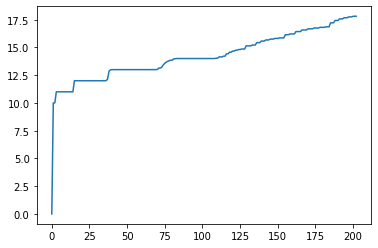

In [52]:
print(parameters.eval.shape)
plt.plot(parameters.eval)

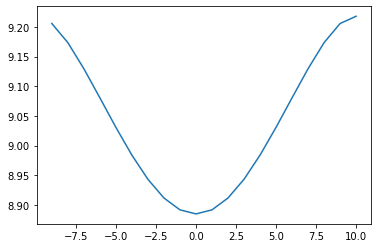

In [48]:
import pandas as pd
pd_file=pd.read_csv('/Users/livi/Git/exciton1d-1/example_disp.csv')
plt.plot(pd_file[' k'],pd_file['energy'])

# Parameter Out

In [ ]:
'''!*********************************************************************!
!        Write the simulation parameters to a file so that the        !
!   simulation can be reproduced at a later time.                     !
!*********************************************************************!'''
def para_out(p):
    #integer f_no
    #character*100 f_name
    f_name =task_title+'_para.csv'
    with open(f_name) as para_wf:
        write('parameter, values, all energies in cm-1')
        write('task title, ',           trim(p.task_title))
        write('nmol, ',                 p.nmol)
        write('vibmax, ',               p.vibmax)
        write('@@@@@@,@@@@@@')
        write('basis state, on')
        write('1p, ',                   p.one_state)
        write('2p, ',                   p.two_state)
        write('ct, ',                   p.ct_state)
        write('total,',                 p.kount)
        write('@@@@@@,@@@@@@')
        write('vib energy,',            p.hw)
        write('lambda,',                p.lambda_n)
        write('lambda+,',               p.lambda_c)
        write('lambda-',                p.lambda_a)
        write('JCoul,',                 p.JCoul*p.hw)
        write('ES1,',                   p.ES1*p.hw)
        write('te,',                    p.te*p.hw)
        write('th,',                    p.th*p.hw)
        write('ECT,',                   p.ECT*p.hw)
        write('@@@@@@@@,@@@@@@@@')
        write('abs linewidth,',         p.abs_lw*p.hw)

# Main Exciton

In [ ]:
#def exciton_main():
#read the user input file and set simulation parameters
parameters=load_commonvar()
parameters=read_in_para(parameters)
#index the multiparticle basis set
parameters.kount = 0
if (parameters.one_state):
    index_1p(parameters)
if (parameters.two_state):
    index_2p(parameters)
if (parameters.ct_state):
    index_ct(parameters)

#make sure the number of requested eigenstates is less than the
#total number of eigenstates possible
parameters.esnum = min(parameters.esnum,parameters.kount) 

#build the franck-condon table for the vibrational overlap factors
set_fctable(parameters)  
#allocate space for the Hamiltonian matrix and eigenvalue array
parameters.h=np.zeros([parameters.kount+1,parameters.kount+1],dtype=complex) # !the Hamiltonian
parameters.eval=np.zeros([parameters.kount])    # !eigenvalues

print('(a)', ' Will now build the Hamiltonian, the diminsion of each k-block is:')
print(parameters.kount)
print('********************************************************************')


#build each k-block of the Hamiltonian diagonalize, and calculate the observables
for k in range(parameters.nlbnd,parameters.nubnd):
    #!initialize hamiltonian to zero
    #h = complex_zero
    #build the hamiltonian
    if ( parameters.one_state ):
        build_h1p(k,parameters)
    if ( parameters.two_state ):
        build_h2p(k,parameters)
    if ( parameters.one_state) and (parameters.two_state ):
        build_h1p2p(k,parameters)
    if ( parameters.ct_state ):
        build_hct(k,parameters)
    if ( parameters.one_state) and (parameters.ct_state ):
        build_h1pct(k,parameters)
    if (parameters.two_state) and (parameters.ct_state ):
        build_h2pct(k,parameters)

    #diagonalize the hamiltonian
    if ( k == 0) or (esnum == kount ):
        diagonalize(h, kount, eval, 'A', kount)
    else:
        diagonalize(h, kount, eval, 'I', esnum)
    
    #calculate absorption spectrum
    #(only k=0 absorbes assuming parallel dipoles)
    if ( k == 0 ):
        absorption(parameters)
    dispersion(k,parameters)
    
    print('Done with wavevector k: ', k)

para_out()
print('********************************************************************')
print('Program exited successfully.')
        
    

In [ ]:
#program exciton_main
    #integer k   !the k-index
    
    #!read the user input file and set simulation parameters 
   
    #index the multiparticle basis set
    
    #make sure the number of requested eigenstates is less than the
    #total number of eigenstates possible

    #build the franck-condon table for the vibrational overlap factors
    
    #allocate space for the Hamiltonian matrix and eigenvalue array
    #allocate ( h(kount,kount) ) !the Hamiltonian
    #allocate ( eval(kount) )    !eigenvalues
    
    #build each k-block of the Hamiltonian diagonalize, and calculate the observables

    #write the parameter file
    


In [24]:
parameters.fc_gf.transpose()

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.60653066, -0.42888194, -0.2476151 ],
       [ 0.        ,  0.42888194, -0.90979599, -0.8754516 ],
       [ 0.        , -0.2476151 ,  0.8754516 , -1.01088443]])

In [21]:
  gf='0.60653065971263342       0.60653065971263342       0.42888194248035344       0.24761510494160160       0.12380755247080080      -0.60653065971263342        0.0000000000000000       0.42888194248035344       0.49523020988320327       0.37142265741240243       0.42888194248035344      -0.42888194248035344      -0.30326532985631671       0.17509031982842507       0.43772579957106278      -0.24761510494160160       0.49523020988320327      -0.17509031982842507      -0.40435377314175563       -5.0544221642719475E-002  0.12380755247080080      -0.37142265741240243       0.43772579957106278        5.0544221642719475E-002 -0.37908166232039564'
  np.reshape(np.asarray(gf.split(),'float'),(5,5))

array([[ 0.60653066,  0.60653066,  0.42888194,  0.2476151 ,  0.12380755],
       [-0.60653066,  0.        ,  0.42888194,  0.49523021,  0.37142266],
       [ 0.42888194, -0.42888194, -0.30326533,  0.17509032,  0.4377258 ],
       [-0.2476151 ,  0.49523021, -0.17509032, -0.40435377, -0.05054422],
       [ 0.12380755, -0.37142266,  0.4377258 ,  0.05054422, -0.37908166]])

********************************************************************
 Calculating derived parameters in units of hw.
  0.60653065971263342       0.60653065971263342       0.42888194248035344       0.24761510494160160       0.12380755247080080      -0.60653065971263342        0.0000000000000000       0.42888194248035344       0.49523020988320327       0.37142265741240243       0.42888194248035344      -0.42888194248035344      -0.30326532985631671       0.17509031982842507       0.43772579957106278      -0.24761510494160160       0.49523020988320327      -0.17509031982842507      -0.40435377314175563       -5.0544221642719475E-002  0.12380755247080080      -0.37142265741240243       0.43772579957106278        5.0544221642719475E-002 -0.37908166232039564     
 ***************************************
  0.88249690258459546       0.44124845129229773       0.15600488604842289        4.5034731477476914E-002   1.1258682869369228E-002 -0.44124845129229773       0.66187267693844665       0.54601710116948010       0.24769102312612301        8.4440121520269223E-002  0.15600488604842289      -0.54601710116948010       0.46882647949806633       0.58115964330366532       0.32043391291743195       -4.5034731477476914E-002  0.24769102312612301      -0.58115964330366532       0.30106014124630726       0.57856405006685385        1.1258682869369228E-002  -8.4440121520269223E-002  0.32043391291743195      -0.57856405006685385       0.15641912872959382     
 ***************************************
  0.88249690258459546       0.44124845129229773       0.15600488604842289        4.5034731477476914E-002   1.1258682869369228E-002 -0.44124845129229773       0.66187267693844665       0.54601710116948010       0.24769102312612301        8.4440121520269223E-002  0.15600488604842289      -0.54601710116948010       0.46882647949806633       0.58115964330366532       0.32043391291743195       -4.5034731477476914E-002  0.24769102312612301      -0.58115964330366532       0.30106014124630726       0.57856405006685385        1.1258682869369228E-002  -8.4440121520269223E-002  0.32043391291743195      -0.57856405006685385       0.15641912872959382     
 ***************************************
  0.88249690258459546       0.44124845129229773       0.15600488604842289        4.5034731477476914E-002   1.1258682869369228E-002 -0.44124845129229773       0.66187267693844665       0.54601710116948010       0.24769102312612301        8.4440121520269223E-002  0.15600488604842289      -0.54601710116948010       0.46882647949806633       0.58115964330366532       0.32043391291743195       -4.5034731477476914E-002  0.24769102312612301      -0.58115964330366532       0.30106014124630726       0.57856405006685385        1.1258682869369228E-002  -8.4440121520269223E-002  0.32043391291743195      -0.57856405006685385       0.15641912872959382     
 ***************************************
  0.88249690258459546       0.44124845129229773       0.15600488604842289        4.5034731477476914E-002   1.1258682869369228E-002 -0.44124845129229773       0.66187267693844665       0.54601710116948010       0.24769102312612301        8.4440121520269223E-002  0.15600488604842289      -0.54601710116948010       0.46882647949806633       0.58115964330366532       0.32043391291743195       -4.5034731477476914E-002  0.24769102312612301      -0.58115964330366532       0.30106014124630726       0.57856405006685385        1.1258682869369228E-002  -8.4440121520269223E-002  0.32043391291743195      -0.57856405006685385       0.15641912872959382     
 ***************************************